# 1. Tipos de fronteras en Clasificación

Generación de los conjuntos

In [ ]:
from sklearn.utils import check_random_state
import numpy as np

n_samples=500
mean = (0,-4)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
np.random.seed(14)
datos1 = np.random.multivariate_normal(mean, C, n_samples)
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T

generator = check_random_state(64)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

**a)** Construya el conjunto de datos (dataset) común con los dos conjuntos generados. Luego se realiza un shift desde el conjunto 2 al 1, esto se puede ver en la imagen anterior, donde el conjunto de color naranjo (media luna) tiene puntos azules a la derecha pertenecientes al otro conjunto, esto es con el mismo propósito de trabajar con un dataset no ideal. Determine cuántos registros contiene cada conjunto y visualícelos.


In [ ]:
import matplotlib.pyplot as plt

X = np.concatenate((datos1, datos2), axis=0)
n = 20 #ruido/noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

**(b)** Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
model_LDA.fit(X,y)
visualize_border(model_LDA,X,y,"LDAs")

**c)** Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribucién de probabilidad asumen cada uno?

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model_QDA = QDA()
model_QDA.fit(X,y)
visualize_border(model_QDA,X,y,"QDA")

**d)** Compare cuantitativamente los clasificadores LDA Y QDA en este dataset sintético mediante la métrica de error de clasificación.

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_LDA = model_LDA.predict(X)
y_pred_QDA = model_QDA.predict(X)
print("Miss Classification Loss for LDA: %f"%(1-accuracy_score(y, y_pred_LDA)))
print("Miss Classification Loss for QDA: %f"%(1-accuracy_score(y, y_pred_QDA)))

**e)** Construya una función que entrene/ajuste un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$), experimente con distintos valores del parámetro de regularización mediante el gráfico interactivo. Explique el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [ ]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)

from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

p_min = 0.001
p_max = 1
interactive(visualize_border_interactive,param=(p_min,p_max, 0.001))

# 2. Análisis de audios como datos brutos

# 3. Análisis de emociones en tweets

**a)** Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
tweets = pd.read_csv('./data/text_emotion.csv')
tweets.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [2]:
clases = pd.DataFrame(tweets['sentiment'].value_counts().reset_index())
clases.columns = ["sentiment", "count"]
clases

,sentiment,count
0,neutral,8638
1,worry,8459
2,happiness,5209
3,sadness,5165
4,love,3842
5,surprise,2187
6,fun,1776
7,relief,1526
8,hate,1323
9,empty,827


El dataset cuenta con cuatro columnas, las que corresponden a el id del tweet, el autor y el contenido de este, junto con el sentimiento asociado al contenido.
Los sentimientos encontrados son 13, contando "neutral" como uno de ellos.

**b)** Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

La máscara se aplicará después de pre-procesar el dataset y antes de entrenar el clasificador

**c)** Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [3]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jupy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = tweets.copy()

ps = PorterStemmer()
sw = stopwords.words('english')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

df['norm_content'] = df['content'].apply(lambda x: tknzr.tokenize(x.lower()))
df['norm_content'] = df['norm_content'].apply(lambda x: [w for w in x if (w not in sw and len(w)>2)])
df['norm_content'] = df['norm_content'].apply(lambda x: [ps.stem(w) for w in x])
df.head()

,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


Ahora se hace la separación de test - train

In [6]:
import numpy as np
np.random.seed(14)
msk = np.random.rand(len(df)) < 0.8

# manual preprocess
df_train = df[msk].copy()
df_test = df[~msk].copy()

# default countvector preprocess
df_train_df = df[msk].copy()

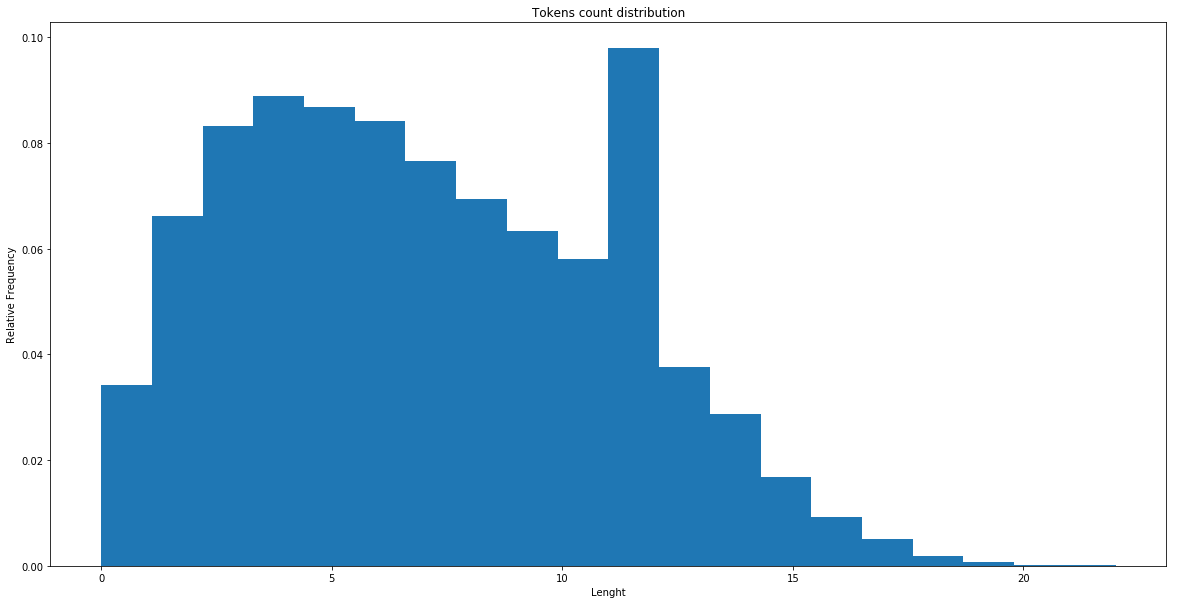

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
gaussian_numbers = df_train['norm_content'].map(len)
plt.hist(gaussian_numbers, bins=20, normed=True)
plt.title("Tokens count distribution")
plt.xlabel("Lenght")
plt.ylabel("Relative Frequency")
plt.show()

In [8]:
df_train = df_train[df_train['norm_content'].map(len) > 1]
df_train = df_train[df_train['norm_content'].map(len) < 14]
df_train.head()

,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ...","[sleep, think, old, friend, want, he', marri, ..."


**d)** Haga una reducción binaria al problema, para trabajarlo como un problema de clasificación de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [9]:
pos = ['neutral', 'happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']

df_train['clase'] = df_train['sentiment'].apply(lambda x: 1 if x in pos else -1)
df_train_df['clase'] = df_train_df['sentiment'].apply(lambda x: 1 if x in pos else -1)

df_test['clase'] = df_test['sentiment'].apply(lambda x: 1 if x in pos else -1)

print(df_train_df['clase'].value_counts()+df_test['clase'].value_counts())
df.head()

 1    23937
-1    16063
Name: clase, dtype: int64


,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


**e)** Construir un clasificador que determine automáticamente la polaridad de un trozo de texto.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def echo(args):
    return args

# Pre-proceso propio
vectorizer = CountVectorizer(tokenizer=echo, preprocessor=echo, lowercase=False)
X_train = vectorizer.fit_transform(df_train['norm_content'])
X_test = vectorizer.transform(df_test['norm_content'])

# Pre-proseso por default de CountVectorizer
vectorizer_df = CountVectorizer()
X_train_df = vectorizer_df.fit_transform(df_train_df['content'])
X_test_df = vectorizer_df.transform(df_test['content'])

**f)** Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificación binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logística, SVM y Arboles de decisión) sobre el conjunto de entrenamiento verificando su desempeño sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gráfico resumen del error de éstos.

In [11]:
def train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    return (model, score_train, score_test)

In [12]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes = train(BernoulliNB(), X_train, df_train['clase'], X_test, df_test['clase'])
naive_bayes_df = train(BernoulliNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(naive_bayes[1],naive_bayes[2]))
print("Naive Bayes df scores: \t train: %.3f \t test: %.3f"%(naive_bayes_df[1],naive_bayes_df[2]))

Naive Bayes scores:    	 train: 0.820 	 test: 0.708
Naive Bayes df scores: 	 train: 0.840 	 test: 0.697


In [13]:
from sklearn.naive_bayes import MultinomialNB
multi_naive_bayes = train(MultinomialNB(), X_train, df_train['clase'], X_test, df_test['clase'])
multi_naive_bayes_df = train(MultinomialNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("Multi Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(multi_naive_bayes[1],multi_naive_bayes[2]))
print("Multi Naive Bayes df scores: \t train: %.3f \t test: %.3f"%(multi_naive_bayes_df[1],multi_naive_bayes_df[2]))

Multi Naive Bayes scores:    	 train: 0.825 	 test: 0.711
Multi Naive Bayes df scores: 	 train: 0.863 	 test: 0.710


In [14]:
from sklearn.linear_model import LogisticRegression
logistic = train(LogisticRegression(), X_train, df_train['clase'], X_test, df_test['clase'])
logistic_df = train(LogisticRegression(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("LogisticRegression scores:    \t train: %.3f \t test: %.3f"%(logistic[1],logistic[2]))
print("LogisticRegression df scores: \t train: %.3f \t test: %.3f"%(logistic_df[1],logistic_df[2]))

LogisticRegression scores:    	 train: 0.840 	 test: 0.717
LogisticRegression df scores: 	 train: 0.884 	 test: 0.718


In [15]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = train(DecisionTreeClassifier(), X_train, df_train['clase'], X_test, df_test['clase'])
decision_tree_df = train(DecisionTreeClassifier(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("DecisionTree scores:    \t train: %.3f \t test: %.3f"%(decision_tree[1],decision_tree[2]))
print("DecisionTree df scores: \t train: %.3f \t test: %.3f"%(decision_tree_df[1],decision_tree_df[2]))

DecisionTree scores:    	 train: 0.997 	 test: 0.667
DecisionTree df scores: 	 train: 0.999 	 test: 0.657


In [16]:
from sklearn.linear_model import SGDClassifier
gradient_descent = train(SGDClassifier(max_iter=5,tol=None), X_train, df_train['clase'], X_test, df_test['clase'])
gradient_descent_df = train(SGDClassifier(max_iter=5,tol=None), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

print("SGD scores:    \t train: %.3f \t test: %.3f"%(gradient_descent[1],gradient_descent[2]))
print("SGD df scores: \t train: %.3f \t test: %.3f"%(gradient_descent_df[1],gradient_descent_df[2]))

SGD scores:    	 train: 0.809 	 test: 0.713
SGD df scores: 	 train: 0.820 	 test: 0.703


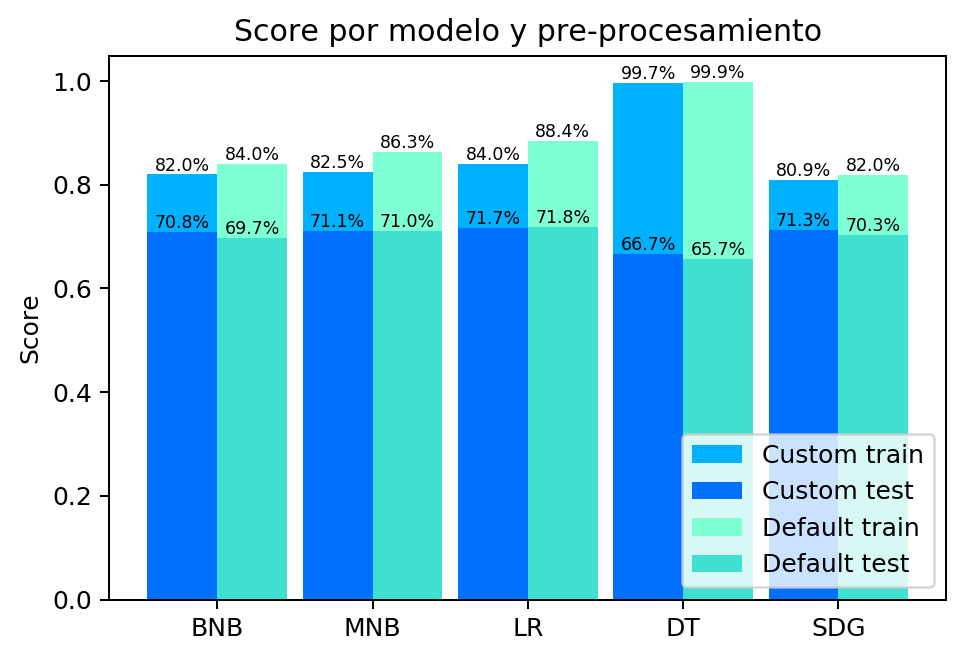

In [17]:
import matplotlib.pyplot as plt
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.45       # the width of the bars

fig, ax = plt.subplots()

test_scores = (naive_bayes[1], multi_naive_bayes[1], logistic[1], decision_tree[1], gradient_descent[1])
train_scores = (naive_bayes[2], multi_naive_bayes[2], logistic[2], decision_tree[2], gradient_descent[2])

rects1 = ax.bar(ind, test_scores, width, color='#00b1ff')
rects1b = ax.bar(ind, train_scores, width, color='#0070ff')

test_scores_df = (naive_bayes_df[1], multi_naive_bayes_df[1], logistic_df[1], decision_tree_df[1], gradient_descent_df[1])
train_scores_df = (naive_bayes_df[2], multi_naive_bayes_df[2], logistic_df[2], decision_tree_df[2], gradient_descent_df[2])

rects2 = ax.bar(ind + width, test_scores_df, width, color='#7fffd4')
rects2b = ax.bar(ind + width, train_scores_df, width, color='#40e0d0')

# add some text for labels, title and axes ticks
ax.set_ylabel('Score')
ax.set_title('Score por modelo y pre-procesamiento')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('BNB', 'MNB', 'LR', 'DT', 'SDG'))

ax.legend((rects1[0], rects1b[0], rects2[0], rects2b[0]), ('Custom train', 'Custom test', 'Default train', 'Default test'), loc='lower right')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%.1f%%' % (100*height),
                ha='center', va='bottom', fontsize = 'x-small')

autolabel(rects1)
autolabel(rects1b)
autolabel(rects2)
autolabel(rects2b)
fig.set_dpi(180)

plt.show()

**g)** Utilice y explique las métricas que calcula la función classification report de la librería sklearn. En base a las distintas métricas calculadas ¿Cuáles clasificadores son los que mejor se comportan?

In [18]:
from sklearn.metrics import classification_report
def score_report(model, X, y, name):
    acc_tr = model[1]
    acc_test = model[2]
    print("Scores for "+name+":")
    print("\tTraining Accuracy: %f"%(acc_tr))
    print("\tTest Accuracy: %f"%(acc_test))
    print("\tDetailed Analysis Testing Results ...")
    print(classification_report(y, model[0].predict(X), target_names=['+','-']))
    print("")

In [19]:
score_report(naive_bayes, X_test, df_test['clase'], "BNB")
score_report(multi_naive_bayes, X_test, df_test['clase'], "MNB")
score_report(logistic, X_test, df_test['clase'], "LR")
score_report(decision_tree, X_test, df_test['clase'], "DT")
score_report(gradient_descent, X_test, df_test['clase'], "SGD")

Scores for BNB:
	Training Accuracy: 0.820020
	Test Accuracy: 0.708427
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.51      0.59      3218
          -       0.72      0.84      0.78      4804

avg / total       0.70      0.71      0.70      8022


Scores for MNB:
	Training Accuracy: 0.824849
	Test Accuracy: 0.710795
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.66      0.59      0.62      3218
          -       0.74      0.79      0.77      4804

avg / total       0.71      0.71      0.71      8022


Scores for LR:
	Training Accuracy: 0.840174
	Test Accuracy: 0.716779
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.55      0.61      3218
          -       0.73      0.83      0.78      4804

avg / total       0.71      0.72      0.71      8022


Scores for DT:
	Training A

**h)** [Opcional] Visualice las predicciones de algún modelo generativo (probabilístico) definido anteriormente, tomando un subconjunto aleatorio de tweets de pruebas y explorando las probabilidades que asigna el clasificador a cada clase.

In [20]:
import random
random.seed(14)
test_pred = logistic[0].predict_proba(X_test)
spl = random.sample(range(len(test_pred)), 15)

print("Negative \t Positive \t Tweet")
for i in spl:
    print(test_pred[i],"\t",df_test.reset_index()['content'][i])

Negative 	 Positive 	 Tweet
[ 0.54433439  0.45566561] 	 On my way to work wish I had more days off
[ 0.24291292  0.75708708] 	 @AprilAMiller Its 5:30 in the evening, sunset time
[ 0.30682213  0.69317787] 	 @mamapigeon I be ok, you?
[ 0.15008159  0.84991841] 	 watchin family guy
[ 0.09632865  0.90367135] 	 @BeSharp wow, great to know a piece of software ensures our timely project delivery  #ProductNamingRulez
[ 0.13828671  0.86171329] 	 @rachky @taltalush Yes. I am secure in my masculinity.
[ 0.14690818  0.85309182] 	 @issacfourth haha dork .. That sounds so yummy .. Share!
[ 0.17926094  0.82073906] 	 @cowmage  read something happy?
[ 0.87789237  0.12210763] 	 Ugh just got out of work i think i'm a dang taxi for ppl but i just can't say no!!!!  o well its my fault
[ 0.75050879  0.24949121] 	 @yourself_onfire I think Letitia is still trying to upload the digital, they were having problems before. I am sure she will let us know
[ 0.61455133  0.38544867] 	 http://twitpic.com/675u6 - Square

**i)** Ahora deberá extender el problema a las múltiples clases que tiene presente (las distintas emociones), es decir, su trabajo será el de predecir una de las distintas emociones de cada _tweet_. Para esto utilice el mismo pre-procesamiento realizado en el punto c) y las características generadas mediante las técnicas en el punto e). Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros.

In [ ]:
clases['value']=[0,-1,1,-2,2,3,4,5,-3,-4,6,-5,-6]
sent = list(clases['sentiment'])
sent_v = list(clases['value'])
df_train['sentiment_class'] = df_train['sentiment'].apply(lambda x: sent_v[sent.index(x)])
df_test['sentiment_class'] = df_test['sentiment'].apply(lambda x: sent_v[sent.index(x)])

df_train.head()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
multi_naive_bayes = train(MultinomialNB(), X_train, df_train['sentiment'], X_test, df_test['sentiment'])

print("Multi Naive Bayes scores:    \t train: %.3f \t test: %.3f"%(multi_naive_bayes[1],multi_naive_bayes[2]))

**j)** Utilice los clasificadores que son extendidos por defecto a múltiples clases para detectar emociones en cada _tweet_, muestre sus desempeños a través del error de pruebas en un gráfico resumen.

**k)** Utilice clasificadores binarios que pueden ser extendidos a través de otras técnicas, tal como One vs One y One vs All/Rest.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
#example
classif = OneVsRestClassifier(model)
classif.fit(X, Y)

**l)** Para el caso de la Regresión Logística compare sus dos métodos para ser extendidos a múltiples clases. Uno a través de One vs Rest y otro definiendo que la variable a predecir se distribuye Multinomial.

**m)** Compare los resultados entre los clasificadores extendidos por defecto y los binarios que son extendidos mediante otras técnicas, construya una tabla o gráfico resumen. Los clasificadores que mejor se comportan en el caso binario ¿Siguen teniendo ese desempeño en múltiples clases?